20200803_01

Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We would like to compute the aperture correction for HST grism extraction when performing on a drz-blot flt frame.

# Background
Aperture correction for original flt frame of HST grisms was presented in ISRs. However, this correction might not be the same when the reduction is performed on a drz-blot flt frame. Theoretically, we would expect drz-blot flt objects to have different PSFs. Therefore, additional correction should be necessary when performing grism reduction on drz-blot flt frame.

# Objectives
- We would like to verify if a grism from drz-blot flt frame is different to that of original flt frame.
- If there is difference, 
 - how much is the difference quantitatively?
 - can we compute the correction values?
 
# Previously...
- 20200731 identified 5 stars in the field. S03 was selected. Flatfielded flt images were done (./rootname_S03/rootname_flt.fits), and they were drizzled and blotted back (./drzblot_S03/idlk01jmq_flt.fits). Code check is required.
 
# Tasks
1. Code check from 20200731.
2. Extract drz
3. Extract flatfielded flt (using the same extraction parameters as drz)
4. Derive aperture correction.
 

In [20]:
from drizzlepac.astrodrizzle import AstroDrizzle
from drizzlepac import ablot
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob,copy,os


# 1. Code check from 20200731


## 1.1. Check flatfieled grism flt

In [6]:
orig = '/Users/kbhirombhakdi/_work/_data/15089/mastDownload/HST/idlk01jmq/idlk01jmq_flt.fits'
new = '/Users/kbhirombhakdi/_work/Sidekicks/20200731/idlk01jmq_S03/idlk01jmq_flt.fits'
flat = '/Users/kbhirombhakdi/_work/Sidekicks/20200731/idlk01jmq_S03/idlk01jmq_S03_fullflat.fits'


In [7]:
of = fits.open(orig)
nf = fits.open(new)
ff = fits.open(flat)


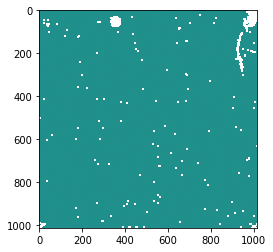

In [17]:
tmp = of[1].data / ff[1].data
tmpp = nf[1].data / tmp
plt.imshow(tmpp,vmin=0.90,vmax=1.10)
# we expect tmpp == 1. for all


In [22]:
pd.DataFrame(tmpp.flatten()).describe()

,0
count,1.026809e+06
mean,1.000000e+00
std,2.794905e-08
min,9.999999e-01
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [23]:
print('Flatfieled grism flt was verified')

Flatfieled grism flt was verified


## 1.2. Check drz
We ran into a problem during 20200731 that we have to turn off the static masking step. However, this seems to be something desirable according to [DrizzlePac manual](https://www.stsci.edu/files/live/sites/www/files/home/scientific-community/software/drizzlepac/_documents/drizzlepac-handbook.pdf).

"Users should consider the details of their science image and decide if creating this
mask is appropriate for the resulting science. For instance, if the image field is very
crowded, or if it contains mostly nebulous or extended objects, the statistics used to
create the static mask could be heavily skewed resulting in a mask that flags sources as
bad pixels." (From section 4.2.2)

# 2. Extract drz

Save ./drzblot_S03/drzblot_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./drzblot_S03/drzblot_trace.csv
Save ./drzblot_S03/drzblot_tbox.csv
Save ./drzblot_S03/drzblot_bbox.csv
Save ./drzblot_S03/drzblot_bbcorner.csv
Save ./drzblot_S03/drzblot_cutout.fits
Save ./drzblot_S03/drzblot_mask.fits
Save ./drzblot_S03/drzblot_bbox.pdf


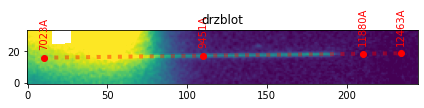

In [76]:
from hstgrism.container import Container
from hstgrism.confreader import ConfReader
from hstgrism.computesip import ComputeSIP
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg102 import WFC3IRG102
from hstgrism.cutout2d import Cutout2D
from hstgrism.flatfield import FlatField
from hstgrism.background import Background
from hstgrism.to_fullframe import to_fullframe
from hstgrism.grismapcorr import GrismApCorr
from hstgrism.show_overview import show_overview
from hstgrism.show_bbox import show_bbox
from hstgrism.show_sum1d import show_sum1d
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import copy
##########
# Make Container
##########
saveprefix = 'drzblot'
savefolder = 'drzblot_S03'
plotformat = 'pdf'
overwrite = False
container_params = {'saveprefix':saveprefix,
                    'savefolder':savefolder,
                    'plotformat':plotformat,
                    'overwrite':overwrite
                   }
containerobj = Container(**container_params)
##########
# Compute xyref
##########
xyd = (610.08939-1,413.55856-1)
confile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/G102.F110W.V4.32.conf'
beam = 'A'
gfile = ('/Users/kbhirombhakdi/_work/Sidekicks/20200731/drzblot_S03/idlk01jmq_flt.fits',1)
dfile = ('/Users/kbhirombhakdi/_work/_data/15089/mastDownload/HST/idlk01jjq/idlk01jjq_flt.fits',1)
xyref_params = {'xyd':xyd,
                'xydiff':'default',
                'xyoff':'default',
                'confile':confile,
                'beam':beam,
                'gfile':gfile,
                'dfile':dfile,
                'container':containerobj
               }
xyrefobj = ComputeXYREF(**xyref_params)
xyrefobj.compute()
xyrefobj.save()
##########
# Map trace and wavelength
##########
xyref = xyrefobj.data['xyref']
grism_params = {'confile':confile,
                'beam':beam,
                'xyref':xyref,
                'container':containerobj
               }
grismobj = WFC3IRG102(**grism_params)
grismobj.compute()
grismobj.save()
##########
# Make cutout
##########
tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
tdata = pd.read_csv(tfile)
xg = tdata.xh + tdata.xyref[0]
yg = tdata.yh + tdata.xyref[1]
halfdy = 5
tbox = {'xg':xg,'yg':yg,'halfdyup':halfdy,'halfdylow':halfdy}
bbox={'padxleft': 10, 'padxright': 10, 'padyup': 10, 'padylow': 10}
image = fits.open(gfile[0])[gfile[1]].data
do_mask = True
cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
cutoutobj.compute(do_mask)
cutoutobj.save()
##########
# show_bbox
##########
show_bbox(cutoutdata=cutoutobj.cutout,
          objname='drzblot',
#           maskdata=cutoutobj.mask,
          maskdata=None,
          do_trace=True,
          xcut=xg - cutoutobj.bbcorner['bb0x'],
          ycut=yg - cutoutobj.bbcorner['bb0y'],
          ww=tdata.ww,
          save=True,container=containerobj
         )


In [77]:
##########
# Background estimation
##########
sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
mfile = ('./{0}/{1}_mask.fits'.format(sfolder,sprefix),1)
gdata = fits.open(gfile[0])[gfile[1]].data 
mdata = fits.open(mfile[0])[mfile[1]].data.astype(bool)
norder = 6
sigclip=(False, 5, 1.)
bkgobj = Background(gdata=gdata,norder=norder,mdata=mdata,sigclip=sigclip,container=containerobj)
bkgobj.poly2d.fit()
bkgobj.save(do_yfit=True,do_maskfit=True)
##########
# Place back to full frame
##########
savesuffix = 'fullbkg'
saveprefix = saveprefix
overwrite = False
containerobj_new = copy.deepcopy(containerobj)
containerobj_new.data['saveprefix'] = saveprefix
containerobj_new.data['overwrite'] = overwrite
cutfile = ('./{0}/{1}_cutbkg.fits'.format(containerobj.data['savefolder'],containerobj.data['saveprefix']),1)
cutdata = fits.open(cutfile[0])[cutfile[1]].data
fullfile = ('/Users/kbhirombhakdi/_work/Sidekicks/20200731/drzblot_S03/idlk01jmq_flt.fits',1)
bb = pd.read_csv('./{0}/{1}_bbcorner.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix']))
bb0x = bb.bb0x[0]
bb1x = bb.bb1x[0]
bb0y = bb.bb0y[0]
bb1y = bb.bb1y[0]
to_fullframe(cutdata,fullfile,
             bb0x,bb1x,bb0y,bb1y,
             savesuffix,containerobj
            )


Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,244.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,33.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 89 invalid data points
data_minmax = (0.5252590179443359,1.6114367246627808) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./drzblot_S03/drzblot_cutbkg.fits
Save ./drzblot_S03/drzblot_maskfit.fits
Make a copy of /Users/kbhirombhakdi/_work/Sidekicks/20200731/drzblot_S03/idlk01jmq_flt.fits to ./drzblot_S03/drzblot_fullbkg.fits


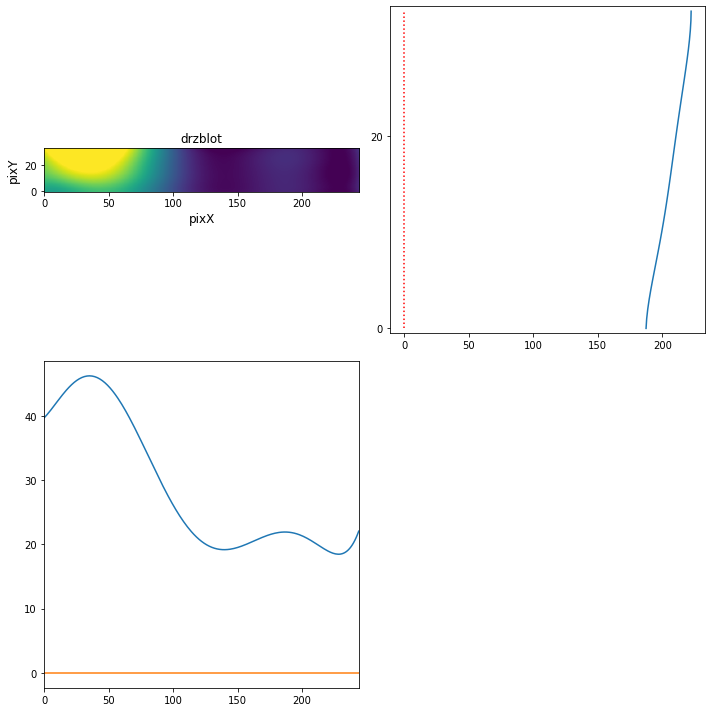

In [78]:
##########
# Diagnostic
##########
# tmpdata = gdata - bkgobj.poly2d.model['YFIT']
tmpdata = bkgobj.poly2d.model['YFIT']
tmpcont = copy.deepcopy(containerobj)
tmpcont.data['saveprefix'] += '_withMASKFIT'
show_sum1d(gdata=tmpdata,objname='drzblot',
#            mdata=bkgobj.poly2d.model['MASKFIT'],
           mdata=None,
           do_zero=True,save=False,container=tmpcont
          )


# Problem
We cannot find a good background estimation. Ideally, we want an isolated object that does not require background subtraction.

Let's try with GD153. Check 02_GD153.ipynb.
